In [1]:
#Intro and Data
import pandas as pd
import quandl

#import Google stock prices from quandl
df = quandl.get("WIKI/GOOGL")

print(df.head())

              Open    High     Low    Close      Volume  Ex-Dividend  \
Date                                                                   
2004-08-19  100.01  104.06   95.96  100.335  44659000.0          0.0   
2004-08-20  101.01  109.08  100.50  108.310  22834300.0          0.0   
2004-08-23  110.76  113.48  109.05  109.400  18256100.0          0.0   
2004-08-24  111.24  111.60  103.57  104.870  15247300.0          0.0   
2004-08-25  104.76  108.00  103.88  106.000   9188600.0          0.0   

            Split Ratio  Adj. Open  Adj. High   Adj. Low  Adj. Close  \
Date                                                                   
2004-08-19          1.0  50.159839  52.191109  48.128568   50.322842   
2004-08-20          1.0  50.661387  54.708881  50.405597   54.322689   
2004-08-23          1.0  55.551482  56.915693  54.693835   54.869377   
2004-08-24          1.0  55.792225  55.972783  51.945350   52.597363   
2004-08-25          1.0  52.542193  54.167209  52.100830   53.1

In [2]:
#reduce dataframe to relevant columns
df = df[['Adj. Open', 'Adj. High','Adj. Low', 'Adj. Close','Adj. Volume']]

#create a new column of High-Low percentage
df['hl_pct'] = (df['Adj. High']- df['Adj. Low']) / df['Adj. Low'] * 100.0

#create a new column of %spread (measure of volatility)
df['pct_change'] = (df['Adj. Close'] - df['Adj. Open']) / df['Adj. Open'] * 100.0

#reduce dataframe to relevant columns
df = df[['Adj. Close', 'hl_pct', 'pct_change','Adj. Volume']]

print(df.head())

            Adj. Close    hl_pct  pct_change  Adj. Volume
Date                                                     
2004-08-19   50.322842  8.441017    0.324968   44659000.0
2004-08-20   54.322689  8.537313    7.227007   22834300.0
2004-08-23   54.869377  4.062357   -1.227880   18256100.0
2004-08-24   52.597363  7.753210   -5.726357   15247300.0
2004-08-25   53.164113  3.966115    1.183658    9188600.0


In [3]:
#Features and Labels
import math
import numpy as np
from sklearn import preprocessing, cross_validation, svm
from sklearn.linear_model import LinearRegression

print(df.isnull().values.any())
#Replace NaN with -99999, even though there are no NaN in df
df.fillna(value=-99999, inplace=True)

#set forecast column variable
forecast_col = 'Adj. Close'
#want to predict out 1% of dataset size (e.g. 1 day for 100 days training)
forecast_out = int(math.ceil(0.01*len(df)))

#make training prediction labels
df['label'] = df[forecast_col].shift(-forecast_out)

False


/opt/anaconda3/lib/python3.5/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [4]:
#Training and testing

#drop NaNs from dataframe
df.dropna(inplace=True)

#split into design matrix X and labels y
X = np.array(df.drop(['label'], 1))
y = np.array(df['label'])

#preprocess X by scaling to ~N(0,1)
X = preprocessing.scale(X)

#split data into train and test sets
X_train, X_test, y_train, y_test = cross_validation.train_test_split(X, y, test_size=0.2)

#fit SVMs with different kernels
for k in ['linear','poly','rbf','sigmoid']:
    clf = svm.SVR(kernel=k)
    clf.fit(X_train, y_train)
    rsq = clf.score(X_test, y_test) #R^2: %variance explained
    print(k,rsq)

clf2 = LinearRegression(n_jobs=-1)
clf2.fit(X_train, y_train)
rsq2 = clf2.score(X_test, y_test)
print("\nlinear regression "+ str(rsq2))

linear 0.97176004864
poly 0.716216359858
rbf 0.818271143079
sigmoid 0.895777641121

linear regression 0.972495717513


In [5]:
#Predicting
X_lately = X[-forecast_out:]
X = X[:-forecast_out]
y_lately = y[-forecast_out:]
y = y[:-forecast_out]

X_train, X_test, y_train, y_test = cross_validation.train_test_split(X,y,test_size=0.2)
clf3 = LinearRegression(n_jobs=-1)
clf3.fit(X_train, y_train)
rsq3 = clf3.score(X_test, y_test)

forecast_set = clf3.predict(X_lately)

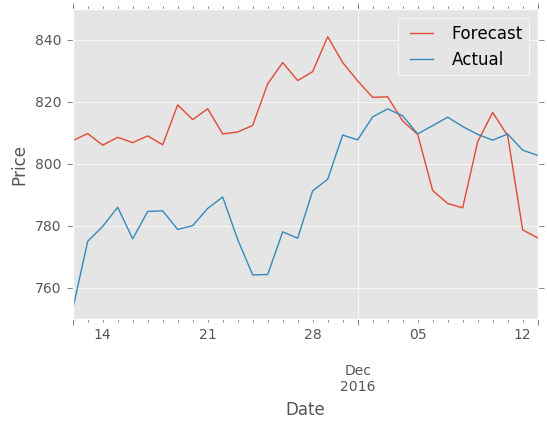

In [6]:
#Plotting
import datetime
import matplotlib.pyplot as plt
from matplotlib import style

style.use('ggplot')

df['Forecast'] = np.nan

last_date = df.iloc[-1].name
last_unix = last_date.timestamp()
one_day = 24*60*60
next_unix = last_unix + one_day

for i in forecast_set:
    next_date = datetime.datetime.fromtimestamp(next_unix)
    next_unix += one_day
    df.loc[next_date] = [np.nan for _ in range(len(df.columns)-1)]+[i]
    
plotdata = df[-forecast_out:]
plotdata = plotdata[['Forecast']]
plotdata['Actual'] = y_lately

plotdata['Forecast'].plot()
plotdata['Actual'].plot()
plt.legend(loc=1)
plt.xlabel('Date')
plt.ylabel('Price')
plt.show()

In [10]:
#Pickling and scaling
import pickle

with open('linearregression.pickle', 'wb') as f:
    pickle.dump(clf3, f)

#re-load the linear model into a different variable
#just to use pickle, even though it's already saved
pickle_in = open('linearregression.pickle','rb')
linmodel = pickle.load(pickle_in)

#nothing to do for scaling, the tutorial just introduces AWS, etc.

#the tutorial goes through programming linear regression manually,
#which I already did in R following ESL

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=-1, normalize=False)
